# Potential Host Counting

One early question we we want to ask is "How many possible host galaxies are there in each image?" ([#4](https://github.com/chengsoonong/crowdastro/issues/4)). To answer this question I will first need to determine how confidently labelled each example is, a question which is covered in Banfield et al. (2015). This will allow me to find the dimmest confidently classified example. This will then be the lower brightness threshold for potential hosts. Finally, I will count how many hosts are in each image.

Every subject has some associated classifications (from which I will eventually derive the labels). There are usually multiple classifications. The *consensus* for a given subject is defined by Banfield et al. as

$$
C = \frac{n_{\text{consensus}}}{n_{\text{all}}}
$$

where $n_{\text{consensus}}$ is the number of classifications in agreement with the most common classification for a subject, and $n_{\text{all}}$ is the total number of classifications for the subject.

How do we determine "agreement"? There are two components to this: agreement on which radio observations are components of the same source, and agreement on which infrared source is the host galaxy. Radio observation agreement is easy since participants select predefined contours and these are included in the dataset. The classification itself, however, is an $(x, y)$ coordinate. These coordinates could vary but still represent the same infrared source. I'll follow the approach taken by Banfield et al. and use a kernel-density estimator (KDE) with the click locations. The Banfield et al. paper gives no threshold for whether two clicks are counted as agreeing, so I will have to choose this threshold myself (which I will do later, once I have seen some data).

An implementation of the consensus computation is located [here](https://github.com/willettk/rgz-analysis) for Python 2. I'll be doing something quite similar here.

For this notebook, I'll use the same subject as Banfield et al.: FIRSTJ124610.0+384838 (ARG000180p).

## Setting up the data

This section just loads the subject and shows it, along with all associated clicks.

In [168]:
import collections
import io
import itertools
import pprint

import matplotlib.pyplot
import numpy
import PIL
import pymongo
import requests
import skimage.exposure
import skimage.feature
import scipy.ndimage.filters
import scipy.ndimage.morphology
import scipy.stats

%matplotlib inline

HOST = 'localhost'
PORT = 27017
DB_NAME = 'radio'

IMAGE_SCALE = 500/424

In [2]:
# Setup MongoDB.
client = pymongo.MongoClient(HOST, PORT)
db = client[DB_NAME]

In [3]:
# Load the subject.
subject = db.radio_subjects.find_one({'zooniverse_id': 'ARG000180p'})

In [4]:
# Download the images associated with this subject.
infrared = PIL.Image.open(io.BytesIO(requests.get(subject['location']['standard']).content))
radio = PIL.Image.open(io.BytesIO(requests.get(subject['location']['radio']).content))
combined = PIL.Image.blend(infrared, radio, 0.5)

In [5]:
# Find the classifications associated with this subject.
classifications = list(db.radio_classifications.find({'subject_ids': subject['_id']}))

An example classification:

```python
{'_id': ObjectId('52b1dd4e4258ec455d001f91'),
 'annotations': [{'ir': {'0': {'x': '251.5', 'y': '212'}},
                  'radio': {'0': {'xmax': '102.32255232729742',
                                  'xmin': '87.5456431846481',
                                  'ymax': '72.12894883061881',
                                  'ymin': '62.77882105432897'},
                            '1': {'xmax': '71.01281894294526',
                                  'xmin': '56.02975587403343',
                                  'ymax': '69.5085910834056',
                                  'ymin': '62.2958306709543'}}},
                 {'finished_at': '',
                  'started_at': ''},
                 {'user_agent': ''}],
 'created_at': datetime.datetime(2013, 12, 18, 17, 37, 19),
 'project_id': ObjectId('52afdb804d69636532000001'),
 'subject_ids': [ObjectId('52af820baf2fdc059a005621')],
 'subjects': [{'id': ObjectId('52af820baf2fdc059a005621'),
               'location': {'contours': 'http://radio.galaxyzoo.org/subjects/contours/52af820baf2fdc059a005621.json',
                            'radio': 'http://radio.galaxyzoo.org/subjects/radio/52af820baf2fdc059a005621.jpg',
                            'standard': 'http://radio.galaxyzoo.org/subjects/standard/52af820baf2fdc059a005621.jpg'},
               'zooniverse_id': 'ARG000180p'}],
 'tutorial': False,
 'updated_at': datetime.datetime(2013, 12, 18, 17, 37, 18, 452000),
 'user_id': ObjectId('52b0a0f62b60f168a9000013'),
 'user_ip': '',
 'user_name': '',
 'workflow_id': ObjectId('52afdb804d69636532000002')}
```

In [6]:
# Get the click locations.
clicks = []
for c in classifications:
    if 'ir' not in c['annotations'][0] or c['annotations'][0]['ir'] == 'No Sources':
        continue
    
    c_clicks = c['annotations'][0]['ir']
    for click in c_clicks.values():
        clicks.append((float(click['x']), float(click['y'])))
clicks = numpy.array(clicks)
clicks_x, clicks_y = clicks.T

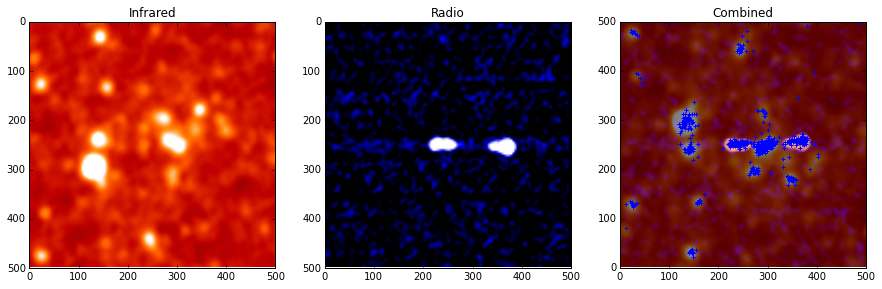

In [7]:
# Plot the images.
matplotlib.pyplot.figure(figsize=(15, 15))
matplotlib.pyplot.subplot(1, 3, 1)
matplotlib.pyplot.imshow(infrared)
matplotlib.pyplot.title('Infrared')
matplotlib.pyplot.subplot(1, 3, 2)
matplotlib.pyplot.imshow(radio)
matplotlib.pyplot.title('Radio')
matplotlib.pyplot.subplot(1, 3, 3)
matplotlib.pyplot.imshow(combined)
matplotlib.pyplot.scatter(clicks_x*IMAGE_SCALE, clicks_y*IMAGE_SCALE, marker='+')
matplotlib.pyplot.xlim((0, 500))
matplotlib.pyplot.ylim((0, 500))
matplotlib.pyplot.title('Combined')
matplotlib.pyplot.show()

The clicks don't line up unless multiplied by a constant. The [data description](https://github.com/willettk/rgz-analysis/blob/master/RadioGalaxyZoo_datadescription.ipynb) mentions a scaling factor but no such factor is included here; instead, this is due to the rescaling of the images for web viewing. The scale factor is $500/424$.

## Calculating Consensus

In [19]:
# List of signatures, immutable objects uniquely representing combinations of radio sources.
radio_signatures = []

# I'll also gather up all the click locations while I'm at it.
# Note that I'm discarding the radio-IR connection; for the purposes of this exercise I don't care about it
# (but this should be taken into consideration later).
clicks = []

for classification in classifications:
    # Generate a radio signature for each classification.
    classification_radio_signature = []

    galaxies = [annotation for annotation in classification['annotations'] if 'ir' in annotation]
    for galaxy in galaxies:
        # Generate a signature for each radio contours combination. This is just a sorted list of all the xmax values
        # associated with radio contours in the combination.
        if galaxy['radio'] == 'No Contours':
            radio_signature = ()
        else:
            radio_signature = tuple(sorted({r['xmax'] for r in galaxy['radio'].values()}))
        classification_radio_signature.append(radio_signature)
        
        if galaxy['ir'] == 'No Sources':
            continue  # Totally ignoring this case for now.
        else:
            # I'm also ignoring the case where there are multiple clicks.
            click = (float(galaxy['ir']['0']['x']), float(galaxy['ir']['0']['y']))
        clicks.append(click)
    
    classification_radio_signature = tuple(sorted(classification_radio_signature))
    radio_signatures.append(classification_radio_signature)

clicks = numpy.array(clicks)

In [9]:
# Sanity check: About 10% of participants split the radio sources.
print(len([s for s in radio_signatures if len(s) == 2])/len(radio_signatures))

0.10923694779116466


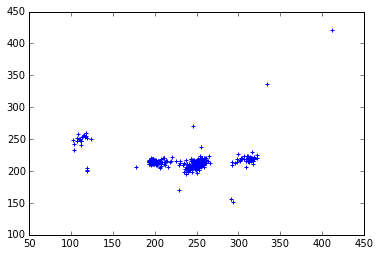

In [20]:
# Sanity check: Let's look at the clicks.
xs, ys = clicks.T
matplotlib.pyplot.scatter(xs, ys, marker='+')
matplotlib.pyplot.show()

In [38]:
# Now we'll check the click location consensus.
# Perform KDE on the clicks.
clicks += numpy.random.normal(size=clicks.shape)
kernel = scipy.stats.kde.gaussian_kde(clicks.T)

In [73]:
X, Y = numpy.mgrid[0:500:500j, 0:500:500j]
positions = numpy.vstack([X.ravel(), Y.ravel()])
density = kernel(positions).T.reshape(X.shape)

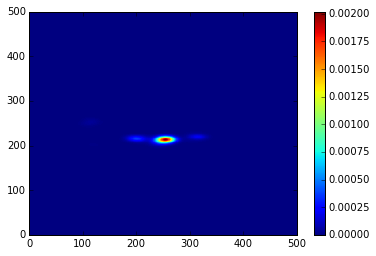

In [74]:
matplotlib.pyplot.pcolor(density.T)
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()

In [69]:
# From https://github.com/willettk/rgz-analysis
neighborhood = numpy.ones((5, 5))
local_max = scipy.ndimage.filters.maximum_filter(density, footprint=neighborhood) == density
eroded_background = scipy.ndimage.morphology.binary_erosion(density == 0, structure=neighborhood, border_value=1)
detected_peaks = local_max ^ eroded_background

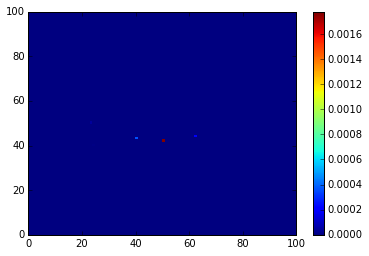

In [70]:
weighted_peaks = detected_peaks * density
matplotlib.pyplot.pcolor(weighted_peaks.T)
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()

In [72]:
click = numpy.unravel_index(weighted_peaks.argmax(), weighted_peaks.shape)
click = click[0] * 5, click[1] * 5
click

(250, 210)

In [176]:
ir_data = numpy.array(infrared.convert('L').getdata()).reshape(infrared.size) / 255
ir_equ = skimage.exposure.equalize_adapthist(ir_data)

K:\Languages\Anaconda\lib\site-packages\skimage\util\dtype.py:111: UserWarning: Possible precision loss when converting from float64 to uint16
  "%s to %s" % (dtypeobj_in, dtypeobj))


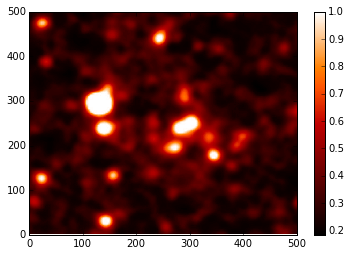

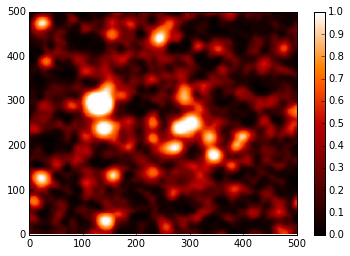

In [177]:
matplotlib.pyplot.pcolor(ir_data, cmap=matplotlib.pyplot.get_cmap('gist_heat'))
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()
matplotlib.pyplot.pcolor(ir_equ, cmap=matplotlib.pyplot.get_cmap('gist_heat'))
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()

In [184]:
features = skimage.feature.blob_log(ir_equ, max_sigma=50, num_sigma=20)
features = features[features[:, 0] > 0]  # Screen features on the edge of the image.
print('Found {} features.'.format(len(features)))

Found 49 features.


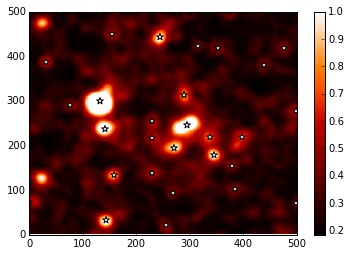

In [185]:
matplotlib.pyplot.pcolor(ir_data, cmap=matplotlib.pyplot.get_cmap('gist_heat'))
matplotlib.pyplot.colorbar()
matplotlib.pyplot.scatter(features[:, 1], features[:, 0], c='white', marker='*', s=50)
matplotlib.pyplot.xlim((0, 500))
matplotlib.pyplot.ylim((0, 500))
matplotlib.pyplot.show()